<a href="https://colab.research.google.com/github/chandini2595/FireSense/blob/main/Colab_Files/DS1_DS2_FeatureImportance_Amalgamation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd

# Load the dataset
file_path = "/content/combined (2).csv"
df = pd.read_csv(file_path)

# Display basic info about the dataset
print("Dataset Info:")
print(df.info())

# Show the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10988 entries, 0 to 10987
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         10988 non-null  object 
 1   county       10988 non-null  object 
 2   maxtempF     10988 non-null  float64
 3   mintempF     10988 non-null  float64
 4   avgtempF     10988 non-null  float64
 5   totalSnow    10988 non-null  float64
 6   humid        10988 non-null  float64
 7   wind         10988 non-null  float64
 8   precip       10988 non-null  float64
 9   q_avgtempF   10988 non-null  float64
 10  q_avghumid   10988 non-null  float64
 11  q_sumprecip  10988 non-null  float64
 12  sunHour      10988 non-null  float64
 13  FIRE_NAME    10988 non-null  object 
 14  CAUSE        10988 non-null  float64
 15  lat          10988 non-null  float64
 16  long         10988 non-null  float64
 17  GIS_ACRES    10988 non-null  float64
dtypes: float64(15), object(3)
memory

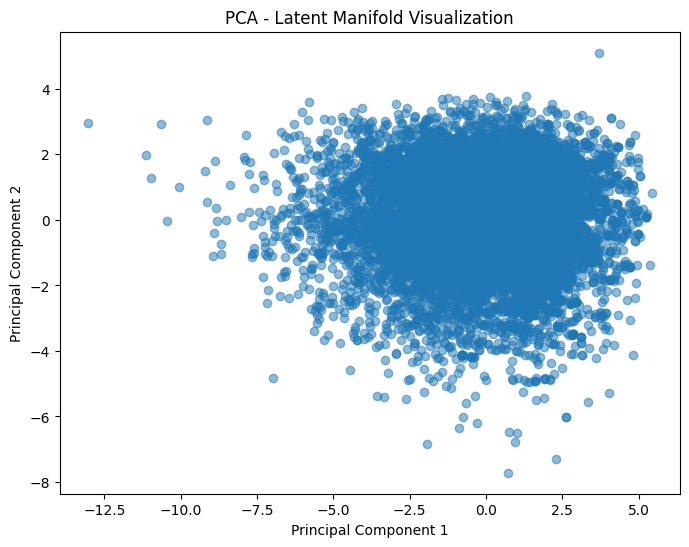

Explained variance ratio: [0.33601935 0.15201556]
Total variance explained by first 2 components: 0.49


In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Selecting only numerical columns for PCA
numerical_cols = df.select_dtypes(include=['float64']).columns
X = df[numerical_cols]

# Standardizing the data (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=2)  # Reduce to 2D for visualization
X_pca = pca.fit_transform(X_scaled)

# Scatter plot of the reduced dimensions
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA - Latent Manifold Visualization")
plt.show()

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print(f"Total variance explained by first 2 components: {sum(explained_variance):.2f}")

In [ ]:
from sklearn.manifold import TSNE

# Applying t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Scatter plot of t-SNE transformed data
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, c=df['CAUSE'], cmap='viridis')
plt.colorbar(label='Fire Cause')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization - Latent Manifold Structure")
plt.show()

In [ ]:
# Adding t-SNE features to the original dataset
df['tsne_1'] = X_tsne[:, 0]
df['tsne_2'] = X_tsne[:, 1]

# Display updated dataset with t-SNE features
print(df[['tsne_1', 'tsne_2']].head())

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define features (excluding categorical and target variables)
feature_cols = [col for col in df.columns if col not in ['date', 'county', 'FIRE_NAME', 'CAUSE']]
X = df[feature_cols]
y = df['CAUSE']  # Target variable (fire cause)

# Train a Random Forest model to assess feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame({'Feature': feature_cols, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance using Random Forest")
plt.gca().invert_yaxis()
plt.show()

# Print top features
print(feature_importances.head(10))

In [ ]:
# Selecting important features based on Random Forest ranking
important_features = feature_importances[feature_importances['Importance'] > 0.010]['Feature'].tolist()
df_selected = df[important_features + ['CAUSE']]  # Keeping target variable

# Display updated dataset with selected features
print("Selected Features for Modeling:", important_features)
print("\nUpdated Dataset Shape:", df_selected.shape)

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df_selected.drop(columns=['CAUSE'])
y = df_selected['CAUSE']

# Splitting data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirm split sizes
print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define MLP model
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("MLP Training Loss")
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MSE: {mse_lr:.2f}, R² Score: {r2_lr:.2f}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf:.2f}, R² Score: {r2_rf:.2f}")

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Train KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict on test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate performance
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN Regressor - MSE: {mse_knn:.2f}, R² Score: {r2_knn:.2f}")

In [ ]:
from xgboost import XGBRegressor

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MSE: {mse_xgb:.2f}, R² Score: {r2_xgb:.2f}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for visualization
results = pd.DataFrame({
    "Actual": y_test,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
    "KNN": y_pred_knn,
    "Linear Regression": y_pred_lr
})

# Plot predictions vs actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=results["Actual"], y=results["Random Forest"], label="Random Forest", alpha=0.5)
sns.scatterplot(x=results["Actual"], y=results["XGBoost"], label="XGBoost", alpha=0.5)
sns.scatterplot(x=results["Actual"], y=results["KNN"], label="KNN", alpha=0.5)
sns.scatterplot(x=results["Actual"], y=results["Linear Regression"], label="Linear Regression", alpha=0.5)
plt.plot(results["Actual"], results["Actual"], color='black', linestyle='dashed')  # Perfect predictions line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

In [ ]:
# Calculate errors
errors_rf = y_test - y_pred_rf
errors_xgb = y_test - y_pred_xgb
errors_knn = y_test - y_pred_knn
errors_lr = y_test - y_pred_lr

# Plot error distribution
plt.figure(figsize=(8, 6))
sns.histplot(errors_rf, bins=30, label="Random Forest", kde=True, color="blue")
sns.histplot(errors_xgb, bins=30, label="XGBoost", kde=True, color="green")
sns.histplot(errors_knn, bins=30, label="KNN", kde=True, color="red")
sns.histplot(errors_lr, bins=30, label="Linear Regression", kde=True, color="orange")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution of Models")
plt.legend()
plt.show()

#Classification


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert FIRE_NAME to binary classification target
df_classification = df_selected.copy()
df_classification['fire_occurred'] = (df['FIRE_NAME'] != 'no_fire').astype(int)

# Define features and target
X = df_classification.drop(columns=['CAUSE', 'fire_occurred'])
y = df_classification['fire_occurred']

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Class distribution in training set:\n", y_train.value_counts(normalize=True))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("AUC-ROC Score:", roc_auc_score(y_test, y_prob_lr))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC Score:", roc_auc_score(y_test, y_prob_rf))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn_model.predict(X_test)
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

print("KNN Results:")
print(classification_report(y_test, y_pred_knn))
print("AUC-ROC Score:", roc_auc_score(y_test, y_prob_knn))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define MLP model
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
mlp_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict and evaluate
y_prob_mlp = mlp_model.predict(X_test).flatten()
y_pred_mlp = (y_prob_mlp > 0.5).astype(int)

print("MLP Neural Network Results:")
print(classification_report(y_test, y_pred_mlp))
print("AUC-ROC Score:", roc_auc_score(y_test, y_prob_mlp))

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot(fpr_knn, tpr_knn, label="KNN")
plt.plot(fpr_mlp, tpr_mlp, label="MLP Neural Network")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Fire Classification")
plt.legend()
plt.show()

In [ ]:
import pandas as pd

# Store classification results in a DataFrame
classification_results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "KNN", "MLP Neural Network"],
    "Accuracy": [
        lr_model.score(X_test, y_test),
        rf_model.score(X_test, y_test),
        knn_model.score(X_test, y_test),
        mlp_model.evaluate(X_test, y_test, verbose=0)[1]
    ],
    "Precision": [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_knn, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_mlp, output_dict=True)['1']['precision'],
    ],
    "Recall": [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_knn, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_mlp, output_dict=True)['1']['recall'],
    ],
    "F1-score": [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_knn, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_mlp, output_dict=True)['1']['f1-score'],
    ],
    "AUC-ROC": [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_knn),
        roc_auc_score(y_test, y_prob_mlp),
    ]
})
# Transpose the DataFrame to have models as columns and metrics as rows
classification_results_transposed = classification_results.set_index("Model").T

# Display the transposed DataFrame
from IPython.display import display
display(classification_results_transposed)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transpose DataFrame to have models as columns and metrics as rows
classification_results_transposed = classification_results.set_index("Model").T

# Plot the results
plt.figure(figsize=(10, 5))
classification_results_transposed.plot(kind="bar", figsize=(12, 5), width=0.8)

plt.title("Model Performance Across Classification Metrics of DS1 + DS2")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.xticks(rotation=0)
plt.legend(title="Model", loc="upper right")

plt.show()